In [1]:
import torch
import tensorflow
from tensorflow.python.client import device_lib
def print_info():
    print('  Versión de TensorFlow: {}'.format(tensorflow.__version__))
    print('  GPU: {}'.format([x.physical_device_desc for x in device_lib.list_local_devices() if x.device_type == 'GPU']))
    print('  Versión Cuda  -> {}'.format(tensorflow.sysconfig.get_build_info()['cuda_version']))
    print('  Versión Cudnn -> {}\n'.format(tensorflow.sysconfig.get_build_info()['cudnn_version']))

print_info()

  Versión de TensorFlow: 2.9.0
  GPU: ['device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5']
  Versión Cuda  -> 64_112
  Versión Cudnn -> 64_8



In [2]:
#Import from library
from datetime import date, time, datetime
import numpy as np
import cv2
#mediciones librerias
from skimage.measure import label, regionprops, regionprops_table
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KernelDensity
from sklearn.metrics import pairwise_distances
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from scipy.linalg import sqrtm
from scipy.stats import entropy
from scipy.stats import norm
#acomodar imagenes
from os import makedirs
#Importar libreriasfrom numpy import expand_dims
from numpy import mean
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from keras import backend
from numpy.random import randn
from numpy.random import randint
from keras.models import Sequential
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.initializers import RandomNormal
from keras.constraints import Constraint
#from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
# example of loading the mnist dataset
from keras.datasets.mnist import load_data
# load saved models
from keras.models import load_model

In [3]:
## Creacion de Dataset
data_img=[]
for num in range(1,5201):
    num_img = str(num).rjust(5,'0')
    dir_img = 'Imagenes\data_all\{}.png'.format(num_img)
    temp_img= cv2.imread(dir_img, cv2.IMREAD_GRAYSCALE)
    #th, im_th = cv2.threshold(temp_img, 128, 255, cv2.THRESH_BINARY)
    #plt.imshow(temp_img)
    resize = cv2.resize(temp_img,(56,56),interpolation = cv2.INTER_CUBIC)
    data_img.append(resize)
data_img = np.asarray(data_img)
#data_img = data_img / 255.0
#normalizamos
data_img=(data_img-127.5) / 127.5
data_img = data_img.reshape(5200,56,56,1)

(5200, 56, 56, 1)


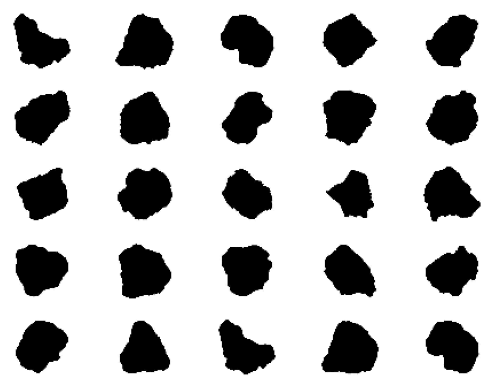

In [4]:
# plot images from the training dataset
for i in range(25):
    # define subplot
    plt.subplot(5, 5, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(data_img[i], cmap='gray_r')
#filename = 'base_plot_2DGAN{}.png'.format(str(date.today()))
#plt.savefig(filename)
#plt.close()
#summarize the shape of the dataset
print(data_img.shape)

In [5]:
# clip model weights to a given hypercube
class ClipConstraint(Constraint):
# set clip value when initialized
    def __init__(self, clip_value):
        self.clip_value = clip_value
# clip model weights to hypercube
    def __call__(self, weights):
        return backend.clip(weights, -self.clip_value, self.clip_value)
# get the config
    def get_config(self):
        return {'clip_value': self.clip_value}


In [6]:
# calculate wasserstein loss
def wasserstein_loss(y_true, y_pred):
    return backend.mean(y_true * y_pred)

In [7]:
# define the standalone critic model
def define_critic(in_shape=(56,56,1)):
    # weight initialization
    init = RandomNormal(stddev=0.2)
    # weight constraint
    const = ClipConstraint(0.01)
    # define model
    model = Sequential()
    #downsample to 14x14
    model.add(Conv2D(64,
                     (3,3),
                     strides=(2,2),
                     padding='same',
                     #kernel_initializer = init,
                     kernel_constraint = const,
                     input_shape=in_shape))
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    #downsample to 7x7
    model.add(Conv2D(64,
                     (3,3),
                     strides=(2,2),
                     padding='same',
                     #kernel_initializer = init,
                     kernel_constraint = const))
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128,
                     (3,3),
                     strides=(2,2),
                     padding='same',
                     #kernel_initializer = init,
                     kernel_constraint = const))
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    #scoring,linear activation
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    
    model.add(Dense(1, activation='linear'))
    
    model.summary()
    #compile model
    opt = RMSprop(learning_rate=0.0005)
    model.compile(optimizer=opt,
                  loss=wasserstein_loss)
    return model

In [8]:

#define the standalone generator model
def define_generator(latent_dim):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    #define model
    model = Sequential()
    #foundation for 7x7 image
    n_nodes =256 *7*7 #features maps*dimensions
    model.add(Dense(n_nodes,
                    #kernel_initializer = init,
                    input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 256)))
    # upsample to 14x14
    model.add(Conv2DTranspose(128,
                              (3,3),
                              strides=(2,2),
                              #kernel_initializer = init,
                              padding='same'
                             ))
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(Conv2DTranspose(128,
                              (3,3),
                              strides=(2,2),
                              #kernel_initializer = init,
                              padding='same'))
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(Conv2DTranspose(64,
                              (3,3),
                              strides=(2,2),
                              #kernel_initializer = init,
                              padding='same'))
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    #output 28x28x1
    model.add(Conv2D(1,
                     (7,7),
                     activation='tanh',
                     #kernel_initializer = init,
                     padding='same'))
    model.summary()
    return model


In [9]:

#define the combined generator and dicriminatro model,
#for updating the generator
def define_gan(generator,critic):
    #make weights in the discriminator not trainable
    critic.trainable = False
    #connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    #add the discriminator
    model.add(critic)
    model.summary()
    #compile model
    opt = RMSprop(learning_rate=0.00005)
    model.compile(optimizer=opt,
                  loss=wasserstein_loss)
    return model


In [10]:

## load and prepare mnist training images
def load_real_samples():
    # load mnist dataset
    #(trainX, _), (_, _) = data_img
    (trainX, trainy), (_, _) = load_data()
    # select all of the examples for a given class
    selected_ix = trainy == 7
    X = trainX[selected_ix]
    # expand to 3d, e.g. add channels dimension
    #X = expand_dims(trainX, axis=-1)
    X = expand_dims(X, axis=-1)
    # convert from unsigned ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1 ,1]
    #X = X / 255.0 #[0 ,1]
    X = (X-127.5) / 127.5
    return X


In [11]:

# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate class labels, -1 for ✬real✬
    y = -ones((n_samples, 1))
    return X, y


In [12]:

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input


In [13]:

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create class labels with 1.0 for ✬fake
    y = ones((n_samples, 1))
    return X, y

In [14]:

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n,n, 1+i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :, 0],
                   cmap='gray_r')
    # save plot to file
    filename = 'results/WGANRe/generated_2WGAN_plot_e%04d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()


In [15]:
def calculate_ssim(images_real, images_generated):
    ssim_scores = []

    for i in range(len(images_real)):
        
        # Desempaqueta las imágenes de un solo canal si es necesario
        img_real = np.squeeze(images_real[i])
        img_generated = np.squeeze(images_generated[i])

        # Calcula el SSIM entre las dos imágenes
        score, _ = ssim(img_real, img_generated, data_range=img_real.max() - img_real.min(), full=True)
        ssim_scores.append(score)

    average_ssim = np.mean(ssim_scores)
    
    return average_ssim

In [16]:
def compute_mmd(real_images, generated_images):
    # Aplanar las imágenes
    real_images_flat = real_images.reshape((len(real_images), -1))
    generated_images_flat = generated_images.reshape((len(generated_images), -1))

    # Calcular las matrices de distancia
    real_distances = pairwise_distances(real_images_flat, real_images_flat)
    generated_distances = pairwise_distances(generated_images_flat, generated_images_flat)
    cross_distances = pairwise_distances(real_images_flat, generated_images_flat)

    # Calcular las estimaciones del kernel
    real_kernel = np.mean(np.exp(-0.5 * real_distances**2))
    generated_kernel = np.mean(np.exp(-0.5 * generated_distances**2))
    cross_kernel = np.mean(np.exp(-0.5 * cross_distances**2))

    # Calcular la MMD
    mmd = real_kernel + generated_kernel - 2 * cross_kernel

    return mmd

In [17]:
def calculate_kde(images_set):
    # Aplanar y normalizar las imágenes
    flattened_images = images_set.reshape((len(images_set), -1))

    # Definir la Estimación de Densidad de Kernel (KDE)
    kde = KernelDensity(bandwidth=0.5)
    kde.fit(flattened_images)

    # Generar nuevos datos para evaluar la densidad de KDE
    num_samples = 1000
    samples = np.random.normal(0, 1, size=(num_samples, flattened_images.shape[1]))

    # Calcular la densidad de KDE en los nuevos datos
    log_density = kde.score_samples(samples)

    # Calcular la entropía de KDE
    entropy_value = -np.mean(log_density)

    return entropy_value


In [18]:
def coverage_metric(real_images, generated_images, k=5):
    # Aplanar las imágenes
    real_images_flat = real_images.reshape((len(real_images), -1))
    generated_images_flat = generated_images.reshape((len(generated_images), -1))

    # Entrenar un modelo de vecinos más cercanos en datos reales
    neighbors_real = NearestNeighbors(n_neighbors=k)
    neighbors_real.fit(real_images_flat)

    # Encontrar los k vecinos más cercanos de cada muestra generada en datos reales
    distances, _ = neighbors_real.kneighbors(generated_images_flat)

    # Calcular la métrica de cobertura como la fracción de muestras generadas que tienen vecinos en datos reales
    coverage = np.mean(np.min(distances, axis=1) <= 0.0)

    return coverage

In [19]:

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model,dataset, latent_dim, n_samples=100):
    # prepare fake examples
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # scale from [-1,1] to [0,1]
    x_fake = (X + 1) / 2.0
    # evaluate the discriminator, plot generated images, save generator model
    Xr, _ = generate_real_samples(dataset, n_samples)
    x_real = Xr*-1
    #evaluate model
    #print(x_fake.shape)
    ssim_score = calculate_ssim(x_real,x_fake)
    
    mmd_score = calculate_ssim(x_real,x_fake)
    
    coverage = coverage_metric(x_real,x_fake)
    
    fake_kde = calculate_kde(x_fake)
    real_kde = calculate_kde(x_real)
    
    save_plot(x_fake, epoch)
    # save the generator model tile file
    #filename = 'results/WGANRi/models/generator_2D_model_%03d.h5' % (epoch + 1)
    #g_model.save(filename)
    return ssim_score,fake_kde,real_kde,mmd_score,coverage#,fid_score



In [20]:
# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist):
    # plot history
    plt.plot(d1_hist, label='crit_real')
    plt.plot(d2_hist, label='crit_fake')
    plt.plot(g_hist, label='gen')
    plt.legend()
    plt.savefig('results/WGANRe/eval/plot_line_plot_loss.png')
    plt.close()

In [21]:
def plot_ssim(ssim):#,fid):
    
    plt.plot(ssim, label = 'ssim score')
    plt.legend()
    
    # save plot to file
    plt.savefig('results/WGANRe/eval/plot_evaluation_ssim.png')
    plt.close()

In [22]:
def plot_coverage(coverage):#,fid):
    
    plt.plot(coverage, label = 'coverage')
    plt.legend()
    
    # save plot to file
    plt.savefig('results/WGANRe/eval/plot_evaluation_coverage.png')
    plt.close()

In [23]:
def plot_mmd(mmd):#,fid):
    
    plt.plot(mmd, label = 'mmd score')
    plt.legend()
    
    # save plot to file
    plt.savefig('results/WGANRe/eval/plot_evaluation_mmd.png')
    plt.close()

In [24]:
def plot_kde(rKde, fKde):#,fid):
    
    plt.plot(rKde, label = 'real KDE')
    plt.plot(fKde, label = 'fake KDE')
    plt.legend()
    
    # save plot to file
    plt.savefig('results/WGANRe/eval/plot_evaluation_KDE.png')
    plt.close()

In [25]:

# train the generator and discriminator
def train(g_model, c_model, gan_model, dataset, latent_dim,
          n_epochs=65, n_batch=48,n_critic=5):
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset.shape[0] / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    
    # lists for keeping track of loss
    c1_hist, c2_hist, g_hist = list(), list(), list()
    
    #prepare lists for storing evaluation each iteration
    ssim,fkde,rkde,mmd,coverage = list(),list(),list(),list(),list()
    
    # manually enumerate epochs
    for i in range(n_steps):
        # update the critic more than the generator
        c1_tmp, c2_tmp = list(), list()
        # enumerate batches over the training set
        for _ in range(n_critic):
            # get randomly selected ✬real✬ samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # generate ✬fake✬ examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
           # update critic model weights
            c_loss1 = c_model.train_on_batch(X_real, y_real)
            #print(c_loss1)
            c1_tmp.append(c_loss1)
            # update critic model weights
            c_loss2 = c_model.train_on_batch(X_fake, y_fake)
            #print(c_loss2)
            c2_tmp.append(c_loss2)
        # store critic loss
        c1_hist.append(mean(c1_tmp))
        c2_hist.append(mean(c2_tmp))
        # prepare points in latent space as input for the generator
        X_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = -ones((n_batch, 1))
        # update the generator via the critic✬s error
        g_loss = gan_model.train_on_batch(X_gan, y_gan)
        #print(g_loss)
        g_hist.append(g_loss)
        # evaluate the model performance every ✬epoch✬
        print('>%d, c1=%.3f, c2=%.3f, g=%.3f' % (i+1,  c1_hist[-1], c2_hist[-1], g_loss))
    
        # evaluate the model performance, sometimes
        if (i+1) % bat_per_epo == 0:
            ssimScore,fKDE,rKDE,mmdScore,cScore = summarize_performance(i, g_model, dataset, latent_dim)
            #epoch, g_model, d_model, dataset, latent_dim,
            ssim.append(ssimScore)
            fkde.append(fKDE)
            rkde.append(rKDE)
            mmd.append(mmdScore)
            coverage.append(cScore)
            
    #line plots of loss
    plot_history(c1_hist, c2_hist, g_hist)
    plot_ssim(ssim)
    plot_kde(rkde,fkde)
    plot_mmd(mmd)
    plot_coverage(coverage)

In [26]:
#Make folder in dir
makedirs('results/WGANRe', exist_ok=True)
makedirs('results/WGANRe/eval', exist_ok=True)
# size of the latent space
latent_dim = 100
# create the discriminator
critic = define_critic()
# create the
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, critic)
# load image data
dataset = data_img
#dataset = load_real_samples()

# train model
train(g_model, critic, gan_model, dataset, latent_dim,n_epochs=10)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0

1/1 [==============================] - 0s 16ms/step
>14, c1=-18481.365, c2=1548.068, g=-1318.099
1/1 [==============================] - 0s 16ms/step
>15, c1=-21006.677, c2=1854.796, g=-1596.091
1/1 [==============================] - 0s 16ms/step
>16, c1=-23759.942, c2=2213.732, g=-1895.524
1/1 [==============================] - 0s 16ms/step
>17, c1=-26224.954, c2=2608.190, g=-2241.785
1/1 [==============================] - 0s 16ms/step
>18, c1=-29554.323, c2=3077.399, g=-2680.295
1/1 [==============================] - 0s 16ms/step
>19, c1=-32469.309, c2=3582.573, g=-3104.095
1/1 [==============================] - 0s 16ms/step
>20, c1=-35672.472, c2=4150.885, g=-3459.911
1/1 [==============================] - 0s 16ms/step
>21, c1=-38814.756, c2=4714.380, g=-4028.939
1/1 [==============================] - 0s 16ms/step
>22, c1=-41916.614, c2=5467.137, g=-4552.092
1/1 [==============================] - 0s 16ms/step
>23, c1=-45195.339, c2=6177.185, g=-5049.558
1/1 [=========================

>40, c1=-117617.755, c2=18067.028, g=-13783.078
1/1 [==============================] - 0s 16ms/step
>41, c1=-123345.386, c2=19057.695, g=-13994.652
1/1 [==============================] - 0s 0s/step
>42, c1=-125956.887, c2=19155.324, g=-13999.690
1/1 [==============================] - 0s 16ms/step
>43, c1=-134354.641, c2=20887.230, g=-13631.754
1/1 [==============================] - 0s 16ms/step
>44, c1=-137160.656, c2=21270.649, g=-15205.396
1/1 [==============================] - 0s 16ms/step
>45, c1=-143382.984, c2=23066.297, g=-14523.500
1/1 [==============================] - 0s 16ms/step
>46, c1=-145843.019, c2=25173.607, g=-15549.903
1/1 [==============================] - 0s 16ms/step
>47, c1=-153502.256, c2=25797.117, g=-16048.599
1/1 [==============================] - 0s 16ms/step
>48, c1=-158845.406, c2=25724.177, g=-14585.745
1/1 [==============================] - 0s 16ms/step
>49, c1=-162165.381, c2=24595.026, g=-13371.559
1/1 [==============================] - 0s 16ms/step
>5

1/1 [==============================] - 0s 16ms/step
>67, c1=-242057.228, c2=-29965.318, g=39377.801
1/1 [==============================] - 0s 0s/step
>68, c1=-243508.381, c2=-30875.536, g=40668.902
1/1 [==============================] - 0s 16ms/step
>69, c1=-253594.528, c2=-32309.724, g=41631.219
1/1 [==============================] - 0s 16ms/step
>70, c1=-264338.484, c2=-33471.211, g=42745.426
1/1 [==============================] - 0s 16ms/step
>71, c1=-266575.844, c2=-35454.285, g=43766.359
1/1 [==============================] - 0s 16ms/step
>72, c1=-274939.556, c2=-35080.124, g=44799.734
1/1 [==============================] - 0s 16ms/step
>73, c1=-293791.544, c2=-36741.192, g=46560.949
1/1 [==============================] - 0s 16ms/step
>74, c1=-300214.275, c2=-38075.829, g=47852.469
1/1 [==============================] - 0s 16ms/step
>75, c1=-301264.481, c2=-38155.205, g=48720.238
1/1 [==============================] - 0s 16ms/step
>76, c1=-302111.225, c2=-40060.332, g=49953.582
1/

1/1 [==============================] - 0s 23ms/step
>94, c1=-492701.319, c2=-58586.028, g=74723.570
1/1 [==============================] - 0s 14ms/step
>95, c1=-494598.800, c2=-60474.507, g=75727.883
1/1 [==============================] - 0s 15ms/step
>96, c1=-511453.156, c2=-62535.003, g=77047.070
1/1 [==============================] - 0s 14ms/step
>97, c1=-520296.650, c2=-60416.235, g=79239.539
1/1 [==============================] - 0s 17ms/step
>98, c1=-524148.013, c2=-63618.953, g=80302.852
1/1 [==============================] - 0s 21ms/step
>99, c1=-545153.425, c2=-63354.984, g=81922.031
1/1 [==============================] - 0s 15ms/step
>100, c1=-548497.275, c2=-60851.169, g=83160.000
1/1 [==============================] - 0s 14ms/step
>101, c1=-574343.363, c2=-64780.075, g=85765.586
1/1 [==============================] - 0s 16ms/step
>102, c1=-569862.525, c2=-64594.747, g=86587.625
1/1 [==============================] - 0s 14ms/step
>103, c1=-596509.037, c2=-63785.290, g=89262.

1/1 [==============================] - 0s 16ms/step
>120, c1=-832463.075, c2=-29179.350, g=78252.438
1/1 [==============================] - 0s 16ms/step
>121, c1=-809615.363, c2=-9610.949, g=80418.742
1/1 [==============================] - 0s 16ms/step
>122, c1=-823225.125, c2=-8381.586, g=70475.258
1/1 [==============================] - 0s 16ms/step
>123, c1=-843785.787, c2=-2460.499, g=57118.719
1/1 [==============================] - 0s 16ms/step
>124, c1=-869212.950, c2=16748.851, g=54965.902
1/1 [==============================] - 0s 16ms/step
>125, c1=-897702.088, c2=17362.079, g=46293.262
1/1 [==============================] - 0s 23ms/step
>126, c1=-921185.425, c2=26672.111, g=33785.145
1/1 [==============================] - 0s 16ms/step
>127, c1=-940987.200, c2=51492.509, g=35740.121
1/1 [==============================] - 0s 16ms/step
>128, c1=-943380.238, c2=20511.374, g=24071.588
1/1 [==============================] - 0s 16ms/step
>129, c1=-918978.287, c2=53528.310, g=30096.139

1/1 [==============================] - 0s 15ms/step
>147, c1=-1167715.475, c2=383681.581, g=-196000.891
1/1 [==============================] - 0s 14ms/step
>148, c1=-1185232.200, c2=354599.594, g=-194198.125
1/1 [==============================] - 0s 14ms/step
>149, c1=-1168291.575, c2=419762.244, g=-285554.719
1/1 [==============================] - 0s 16ms/step
>150, c1=-1193337.925, c2=413583.537, g=-246828.500
1/1 [==============================] - 0s 16ms/step
>151, c1=-1198563.175, c2=440109.213, g=-288477.000
1/1 [==============================] - 0s 15ms/step
>152, c1=-1207022.625, c2=452841.550, g=-301780.031
1/1 [==============================] - 0s 14ms/step
>153, c1=-1209531.050, c2=477197.094, g=-339765.281
1/1 [==============================] - 0s 13ms/step
>154, c1=-1190240.800, c2=515224.862, g=-339433.125
1/1 [==============================] - 0s 14ms/step
>155, c1=-1217662.250, c2=482685.487, g=-365817.719
1/1 [==============================] - 0s 16ms/step
>156, c1=-12

1/1 [==============================] - 0s 16ms/step
>173, c1=-1219578.550, c2=965365.713, g=-727521.812
1/1 [==============================] - 0s 16ms/step
>174, c1=-1211728.150, c2=1005858.762, g=-740156.000
1/1 [==============================] - 0s 16ms/step
>175, c1=-1206782.525, c2=1018520.287, g=-711759.812
1/1 [==============================] - 0s 16ms/step
>176, c1=-1256246.125, c2=1046479.637, g=-743849.500
1/1 [==============================] - 0s 16ms/step
>177, c1=-1223868.550, c2=1039673.525, g=-752584.438
1/1 [==============================] - 0s 16ms/step
>178, c1=-1204501.175, c2=1051746.675, g=-824975.938
1/1 [==============================] - 0s 16ms/step
>179, c1=-1211513.025, c2=1089204.750, g=-757985.188
1/1 [==============================] - 0s 0s/step
>180, c1=-1175211.325, c2=1080400.637, g=-812014.312
1/1 [==============================] - 0s 0s/step
>181, c1=-1168048.175, c2=1131739.025, g=-794432.688
1/1 [==============================] - 0s 16ms/step
>182, c1

1/1 [==============================] - 0s 16ms/step
>199, c1=-630430.900, c2=753689.775, g=-548223.562
1/1 [==============================] - 0s 16ms/step
>200, c1=-595336.075, c2=707107.925, g=-462769.375
1/1 [==============================] - 0s 16ms/step
>201, c1=-494229.406, c2=618500.162, g=-457915.219
1/1 [==============================] - 0s 16ms/step
>202, c1=-464876.188, c2=559250.625, g=-420333.156
1/1 [==============================] - 0s 16ms/step
>203, c1=-403645.331, c2=491979.369, g=-372758.156
1/1 [==============================] - 0s 16ms/step
>204, c1=-357754.713, c2=438353.537, g=-333481.094
1/1 [==============================] - 0s 16ms/step
>205, c1=-314322.181, c2=382036.612, g=-295030.031
1/1 [==============================] - 0s 16ms/step
>206, c1=-297403.338, c2=343208.644, g=-238772.875
1/1 [==============================] - 0s 20ms/step
>207, c1=-270577.731, c2=312335.819, g=-236951.578
1/1 [==============================] - 0s 16ms/step
>208, c1=-244293.200,

1/1 [==============================] - 0s 16ms/step
>225, c1=-128116.617, c2=134028.925, g=-92155.031
1/1 [==============================] - 0s 16ms/step
>226, c1=-125131.994, c2=132512.255, g=-87822.273
1/1 [==============================] - 0s 16ms/step
>227, c1=-119856.575, c2=123904.361, g=-84962.508
1/1 [==============================] - 0s 16ms/step
>228, c1=-116930.152, c2=124990.222, g=-80912.820
1/1 [==============================] - 0s 31ms/step
>229, c1=-110086.833, c2=116152.572, g=-77823.539
1/1 [==============================] - 0s 16ms/step
>230, c1=-105345.942, c2=110522.653, g=-71826.961
1/1 [==============================] - 0s 13ms/step
>231, c1=-102815.430, c2=105060.573, g=-71687.125
1/1 [==============================] - 0s 16ms/step
>232, c1=-99918.580, c2=102387.452, g=-68324.125
1/1 [==============================] - 0s 16ms/step
>233, c1=-102543.066, c2=104342.077, g=-69985.492
1/1 [==============================] - 0s 11ms/step
>234, c1=-103608.363, c2=105707

1/1 [==============================] - 0s 17ms/step
>252, c1=-88816.386, c2=86608.444, g=-63135.707
1/1 [==============================] - 0s 15ms/step
>253, c1=-89356.166, c2=92564.014, g=-65349.969
1/1 [==============================] - 0s 14ms/step
>254, c1=-93947.259, c2=97226.639, g=-63216.875
1/1 [==============================] - 0s 23ms/step
>255, c1=-92124.222, c2=92833.070, g=-64297.406
1/1 [==============================] - 0s 18ms/step
>256, c1=-89970.136, c2=93082.858, g=-61447.770
1/1 [==============================] - 0s 28ms/step
>257, c1=-87726.152, c2=90467.555, g=-64643.375
1/1 [==============================] - 0s 14ms/step
>258, c1=-87202.689, c2=88538.322, g=-61692.953
1/1 [==============================] - 0s 15ms/step
>259, c1=-90696.441, c2=93218.109, g=-71562.477
1/1 [==============================] - 0s 15ms/step
>260, c1=-97600.656, c2=102423.369, g=-74277.789
1/1 [==============================] - 0s 24ms/step
>261, c1=-97511.564, c2=102201.684, g=-72290.49

1/1 [==============================] - 0s 16ms/step
>278, c1=-76735.712, c2=85840.322, g=-66135.680
1/1 [==============================] - 0s 16ms/step
>279, c1=-80048.720, c2=85435.280, g=-71894.656
1/1 [==============================] - 0s 14ms/step
>280, c1=-82390.906, c2=84384.416, g=-72306.680
1/1 [==============================] - 0s 15ms/step
>281, c1=-71463.645, c2=82226.506, g=-70492.344
1/1 [==============================] - 0s 16ms/step
>282, c1=-79066.837, c2=81349.038, g=-70242.367
1/1 [==============================] - 0s 15ms/step
>283, c1=-80877.245, c2=81888.833, g=-73824.328
1/1 [==============================] - 0s 16ms/step
>284, c1=-74494.107, c2=82178.036, g=-71692.383
1/1 [==============================] - 0s 16ms/step
>285, c1=-76222.881, c2=82463.884, g=-72370.281
1/1 [==============================] - 0s 11ms/step
>286, c1=-73002.200, c2=81823.461, g=-67371.305
1/1 [==============================] - 0s 16ms/step
>287, c1=-77944.192, c2=86181.597, g=-76860.695


1/1 [==============================] - 0s 0s/step
>305, c1=-74831.205, c2=85531.955, g=-72816.906
1/1 [==============================] - 0s 16ms/step
>306, c1=-83476.030, c2=88042.744, g=-79457.594
1/1 [==============================] - 0s 16ms/step
>307, c1=-83129.863, c2=89536.598, g=-73485.555
1/1 [==============================] - 0s 16ms/step
>308, c1=-85220.783, c2=90409.634, g=-81968.438
1/1 [==============================] - 0s 16ms/step
>309, c1=-79492.913, c2=87692.650, g=-80621.055
1/1 [==============================] - 0s 16ms/step
>310, c1=-85697.208, c2=89694.673, g=-83637.242
1/1 [==============================] - 0s 16ms/step
>311, c1=-83036.559, c2=88362.267, g=-73673.336
1/1 [==============================] - 0s 16ms/step
>312, c1=-85632.055, c2=91075.464, g=-83801.648
1/1 [==============================] - 0s 16ms/step
>313, c1=-84330.103, c2=90065.675, g=-79993.055
1/1 [==============================] - 0s 33ms/step
>314, c1=-85446.042, c2=90258.542, g=-79322.508
1/

1/1 [==============================] - 0s 18ms/step
>331, c1=-87252.502, c2=89174.617, g=-72881.039
1/1 [==============================] - 0s 14ms/step
>332, c1=-81937.372, c2=90034.531, g=-83008.602
1/1 [==============================] - 0s 20ms/step
>333, c1=-82932.430, c2=88428.272, g=-82178.328
1/1 [==============================] - 0s 15ms/step
>334, c1=-85081.267, c2=87776.148, g=-71592.750
1/1 [==============================] - 0s 15ms/step
>335, c1=-80156.292, c2=88033.161, g=-81548.812
1/1 [==============================] - 0s 20ms/step
>336, c1=-83208.250, c2=87395.814, g=-74472.609
1/1 [==============================] - 0s 16ms/step
>337, c1=-84958.639, c2=88256.767, g=-79664.039
1/1 [==============================] - 0s 10ms/step
>338, c1=-77516.459, c2=85305.206, g=-81679.289
1/1 [==============================] - 0s 10ms/step
>339, c1=-83902.956, c2=86875.814, g=-68436.867
1/1 [==============================] - 0s 13ms/step
>340, c1=-80185.498, c2=86346.414, g=-80565.445


1/1 [==============================] - 0s 16ms/step
>358, c1=-74717.093, c2=81656.195, g=-72738.992
1/1 [==============================] - 0s 16ms/step
>359, c1=-74695.589, c2=79103.587, g=-73327.727
1/1 [==============================] - 0s 16ms/step
>360, c1=-74060.470, c2=79052.488, g=-71537.242
1/1 [==============================] - 0s 12ms/step
>361, c1=-74967.633, c2=78371.745, g=-73271.461
1/1 [==============================] - 0s 16ms/step
>362, c1=-73018.883, c2=76970.478, g=-69213.367
1/1 [==============================] - 0s 16ms/step
>363, c1=-71496.178, c2=76069.497, g=-66794.930
1/1 [==============================] - 0s 16ms/step
>364, c1=-69403.074, c2=75387.545, g=-69612.555
1/1 [==============================] - 0s 11ms/step
>365, c1=-72965.856, c2=75250.341, g=-62329.500
1/1 [==============================] - 0s 16ms/step
>366, c1=-68962.222, c2=74714.661, g=-67157.406
1/1 [==============================] - 0s 16ms/step
>367, c1=-71281.645, c2=74049.291, g=-65583.898


1/1 [==============================] - 0s 16ms/step
>384, c1=-64135.299, c2=68222.856, g=-64420.215
1/1 [==============================] - 0s 16ms/step
>385, c1=-65674.189, c2=68386.659, g=-62002.562
1/1 [==============================] - 0s 16ms/step
>386, c1=-64077.852, c2=67247.216, g=-63080.215
1/1 [==============================] - 0s 29ms/step
>387, c1=-64906.114, c2=67820.423, g=-59473.184
1/1 [==============================] - 0s 6ms/step
>388, c1=-62773.556, c2=66580.038, g=-61561.422
1/1 [==============================] - 0s 5ms/step
>389, c1=-65171.841, c2=67414.644, g=-61767.699
1/1 [==============================] - 0s 16ms/step
>390, c1=-62962.461, c2=66223.966, g=-58727.738
1/1 [==============================] - 0s 16ms/step
>391, c1=-64478.327, c2=66564.228, g=-62490.746
1/1 [==============================] - 0s 16ms/step
>392, c1=-63455.012, c2=66711.461, g=-51884.750
1/1 [==============================] - 0s 16ms/step
>393, c1=-62573.854, c2=65492.737, g=-59586.324
1/

1/1 [==============================] - 0s 21ms/step
>411, c1=-60653.578, c2=64503.076, g=-55756.062
1/1 [==============================] - 0s 14ms/step
>412, c1=-61380.084, c2=65225.637, g=-59794.707
1/1 [==============================] - 0s 17ms/step
>413, c1=-61663.907, c2=65280.260, g=-59679.801
1/1 [==============================] - 0s 15ms/step
>414, c1=-61487.202, c2=64493.547, g=-58887.531
1/1 [==============================] - 0s 16ms/step
>415, c1=-62364.889, c2=64650.348, g=-61564.301
1/1 [==============================] - 0s 16ms/step
>416, c1=-60800.384, c2=65315.150, g=-60366.656
1/1 [==============================] - 0s 16ms/step
>417, c1=-60164.863, c2=64320.650, g=-60111.566
1/1 [==============================] - 0s 10ms/step
>418, c1=-62861.027, c2=65003.095, g=-57985.113
1/1 [==============================] - 0s 16ms/step
>419, c1=-60404.587, c2=65104.328, g=-60417.918
1/1 [==============================] - 0s 16ms/step
>420, c1=-61914.534, c2=65434.654, g=-59993.637


1/1 [==============================] - 0s 44ms/step
>437, c1=-59455.580, c2=63832.172, g=-54556.719
1/1 [==============================] - 0s 20ms/step
>438, c1=-58938.661, c2=63779.153, g=-58954.699
1/1 [==============================] - 0s 20ms/step
>439, c1=-60153.345, c2=63586.043, g=-57805.020
1/1 [==============================] - 0s 18ms/step
>440, c1=-57336.722, c2=61567.848, g=-57913.543
1/1 [==============================] - 0s 17ms/step
>441, c1=-58905.952, c2=62964.241, g=-57489.613
1/1 [==============================] - 0s 15ms/step
>442, c1=-56989.860, c2=62100.665, g=-58522.512
1/1 [==============================] - 0s 20ms/step
>443, c1=-61013.520, c2=63302.641, g=-58417.957
1/1 [==============================] - 0s 27ms/step
>444, c1=-60797.504, c2=64901.380, g=-62130.645
1/1 [==============================] - 0s 24ms/step
>445, c1=-60213.426, c2=64975.131, g=-57499.207
1/1 [==============================] - 0s 19ms/step
>446, c1=-59193.923, c2=63213.713, g=-57640.949


1/1 [==============================] - 0s 17ms/step
>464, c1=-58267.579, c2=62364.557, g=-51896.707
1/1 [==============================] - 0s 16ms/step
>465, c1=-56637.162, c2=60951.940, g=-55971.094
1/1 [==============================] - 0s 17ms/step
>466, c1=-57019.549, c2=60304.580, g=-49799.891
1/1 [==============================] - 0s 16ms/step
>467, c1=-55131.221, c2=59694.262, g=-53571.176
1/1 [==============================] - 0s 18ms/step
>468, c1=-56165.109, c2=59598.991, g=-57288.879
1/1 [==============================] - 0s 14ms/step
>469, c1=-56607.620, c2=60676.288, g=-57278.246
1/1 [==============================] - 0s 13ms/step
>470, c1=-54920.950, c2=60002.924, g=-57329.957
1/1 [==============================] - 0s 15ms/step
>471, c1=-57009.290, c2=60308.799, g=-58102.676
1/1 [==============================] - 0s 21ms/step
>472, c1=-56724.382, c2=61021.067, g=-57911.082
1/1 [==============================] - 0s 21ms/step
>473, c1=-57835.430, c2=61892.334, g=-58140.422


1/1 [==============================] - 0s 18ms/step
>490, c1=-52202.517, c2=55860.615, g=-51745.387
1/1 [==============================] - 0s 28ms/step
>491, c1=-47128.564, c2=55073.002, g=-51639.121
1/1 [==============================] - 0s 19ms/step
>492, c1=-52918.342, c2=55546.848, g=-50832.949
1/1 [==============================] - 0s 15ms/step
>493, c1=-52502.351, c2=55338.604, g=-51962.363
1/1 [==============================] - 0s 19ms/step
>494, c1=-51563.426, c2=55480.728, g=-51488.582
1/1 [==============================] - 0s 16ms/step
>495, c1=-52295.334, c2=55857.995, g=-50397.918
1/1 [==============================] - 0s 18ms/step
>496, c1=-48419.972, c2=54370.795, g=-51769.051
1/1 [==============================] - 0s 18ms/step
>497, c1=-52349.473, c2=54641.829, g=-52011.426
1/1 [==============================] - 0s 15ms/step
>498, c1=-51270.133, c2=54909.710, g=-50947.145
1/1 [==============================] - 0s 18ms/step
>499, c1=-51557.873, c2=54734.777, g=-51017.359


1/1 [==============================] - 0s 17ms/step
>517, c1=-48752.213, c2=52090.132, g=-47935.168
1/1 [==============================] - 0s 17ms/step
>518, c1=-48324.312, c2=51415.628, g=-44478.145
1/1 [==============================] - 0s 17ms/step
>519, c1=-47795.957, c2=51439.111, g=-48659.297
1/1 [==============================] - 0s 18ms/step
>520, c1=-48309.190, c2=51419.951, g=-44433.715
1/1 [==============================] - 0s 17ms/step
>521, c1=-47377.659, c2=51030.690, g=-48955.176
1/1 [==============================] - 0s 15ms/step
>522, c1=-48490.886, c2=52446.453, g=-50052.156
1/1 [==============================] - 0s 17ms/step
>523, c1=-49056.963, c2=52617.010, g=-50178.469
1/1 [==============================] - 0s 15ms/step
>524, c1=-44803.137, c2=51518.768, g=-49971.562
1/1 [==============================] - 0s 16ms/step
>525, c1=-49644.545, c2=51946.416, g=-49126.051
1/1 [==============================] - 0s 20ms/step
>526, c1=-48413.584, c2=52393.066, g=-50741.750


1/1 [==============================] - 0s 22ms/step
>543, c1=-47381.650, c2=51932.444, g=-48769.266
1/1 [==============================] - 0s 22ms/step
>544, c1=-47453.895, c2=51105.759, g=-48781.500
1/1 [==============================] - 0s 22ms/step
>545, c1=-47802.383, c2=50997.720, g=-47150.949
1/1 [==============================] - 0s 16ms/step
>546, c1=-46843.546, c2=50953.059, g=-16516.574
1/1 [==============================] - 0s 15ms/step
>547, c1=-38199.803, c2=48687.050, g=-47647.844
1/1 [==============================] - 0s 16ms/step
>548, c1=-47711.071, c2=50382.773, g=-48218.863
1/1 [==============================] - 0s 14ms/step
>549, c1=-47571.721, c2=50914.241, g=-48215.957
1/1 [==============================] - 0s 15ms/step
>550, c1=-42491.230, c2=49849.221, g=-46693.043
1/1 [==============================] - 0s 16ms/step
>551, c1=-48043.279, c2=50582.540, g=-48739.527
1/1 [==============================] - 0s 15ms/step
>552, c1=-47759.390, c2=50379.950, g=-45320.719


1/1 [==============================] - 0s 24ms/step
>570, c1=-44738.902, c2=50267.666, g=-48290.262
1/1 [==============================] - 0s 23ms/step
>571, c1=-47920.512, c2=50305.547, g=-46728.094
1/1 [==============================] - 0s 15ms/step
>572, c1=-47383.700, c2=50448.758, g=-48132.312
1/1 [==============================] - 0s 20ms/step
>573, c1=-47138.656, c2=50619.755, g=-47872.344
1/1 [==============================] - 0s 15ms/step
>574, c1=-47010.625, c2=50099.931, g=-46723.645
1/1 [==============================] - 0s 15ms/step
>575, c1=-47916.816, c2=50757.537, g=-46430.906
1/1 [==============================] - 0s 17ms/step
>576, c1=-40929.724, c2=49407.841, g=-47335.801
1/1 [==============================] - 0s 17ms/step
>577, c1=-47706.419, c2=49800.571, g=-48057.535
1/1 [==============================] - 0s 18ms/step
>578, c1=-47208.817, c2=49725.562, g=-48033.855
1/1 [==============================] - 0s 17ms/step
>579, c1=-46565.920, c2=49715.945, g=-47655.500


1/1 [==============================] - 0s 17ms/step
>596, c1=-41642.902, c2=44739.730, g=-26669.287
1/1 [==============================] - 0s 18ms/step
>597, c1=-38664.453, c2=44526.317, g=-41272.371
1/1 [==============================] - 0s 19ms/step
>598, c1=-41750.790, c2=44490.702, g=-41267.539
1/1 [==============================] - 0s 16ms/step
>599, c1=-40651.271, c2=43620.412, g=-40193.344
1/1 [==============================] - 0s 17ms/step
>600, c1=-40759.768, c2=43934.582, g=-41227.852
1/1 [==============================] - 0s 15ms/step
>601, c1=-17133.655, c2=20614.605, g=20350.914
1/1 [==============================] - 0s 16ms/step
>602, c1=20524.391, c2=-16361.475, g=20993.113
1/1 [==============================] - 0s 14ms/step
>603, c1=21604.915, c2=-17912.434, g=22362.432
1/1 [==============================] - 0s 16ms/step
>604, c1=22634.296, c2=-20070.329, g=22959.375
1/1 [==============================] - 0s 25ms/step
>605, c1=23356.129, c2=-21547.580, g=23519.096
1/1 [

1/1 [==============================] - 0s 18ms/step
>623, c1=24640.614, c2=-24097.005, g=24693.600
1/1 [==============================] - 0s 17ms/step
>624, c1=24563.223, c2=-24107.604, g=24458.908
1/1 [==============================] - 0s 16ms/step
>625, c1=24511.706, c2=-24015.398, g=24572.500
1/1 [==============================] - 0s 18ms/step
>626, c1=24564.331, c2=-24118.216, g=24829.992
1/1 [==============================] - 0s 18ms/step
>627, c1=24605.093, c2=-24110.735, g=24683.990
1/1 [==============================] - 0s 25ms/step
>628, c1=24565.058, c2=-24057.084, g=24446.953
1/1 [==============================] - 0s 16ms/step
>629, c1=24588.798, c2=-24033.832, g=24539.924
1/1 [==============================] - 0s 18ms/step
>630, c1=24475.688, c2=-24134.678, g=24449.609
1/1 [==============================] - 0s 15ms/step
>631, c1=24465.968, c2=-23982.588, g=24449.631
1/1 [==============================] - 0s 19ms/step
>632, c1=24507.475, c2=-24065.238, g=24501.518
1/1 [=====

1/1 [==============================] - 0s 15ms/step
>649, c1=24447.271, c2=-23906.819, g=24307.182
1/1 [==============================] - 0s 14ms/step
>650, c1=24282.589, c2=-23914.319, g=24252.805
1/1 [==============================] - 0s 14ms/step
>651, c1=24320.820, c2=-23884.714, g=24518.104
1/1 [==============================] - 0s 14ms/step
>652, c1=24363.627, c2=-23903.099, g=24252.600
1/1 [==============================] - 0s 17ms/step
>653, c1=24244.952, c2=-23891.932, g=24301.367
1/1 [==============================] - 0s 15ms/step
>654, c1=24372.388, c2=-23853.909, g=24299.240
1/1 [==============================] - 0s 18ms/step
>655, c1=24295.708, c2=-23829.627, g=24261.365
1/1 [==============================] - 0s 17ms/step
>656, c1=24259.532, c2=-23839.054, g=24290.744
1/1 [==============================] - 0s 15ms/step
>657, c1=24220.611, c2=-23777.441, g=24223.305
1/1 [==============================] - 0s 15ms/step
>658, c1=24333.455, c2=-23836.529, g=24417.631
1/1 [=====

1/1 [==============================] - 0s 14ms/step
>676, c1=24133.763, c2=-23700.461, g=24065.783
1/1 [==============================] - 0s 15ms/step
>677, c1=24062.248, c2=-23689.803, g=24048.775
1/1 [==============================] - 0s 15ms/step
>678, c1=24080.652, c2=-23647.925, g=24049.432
1/1 [==============================] - 0s 15ms/step
>679, c1=24013.669, c2=-23661.207, g=24069.906
1/1 [==============================] - 0s 14ms/step
>680, c1=24059.642, c2=-23594.634, g=24017.268
1/1 [==============================] - 0s 14ms/step
>681, c1=24035.549, c2=-23582.177, g=24043.318
1/1 [==============================] - 0s 14ms/step
>682, c1=24021.896, c2=-23635.673, g=24060.822
1/1 [==============================] - 0s 14ms/step
>683, c1=24025.175, c2=-23572.827, g=24044.562
1/1 [==============================] - 0s 14ms/step
>684, c1=24011.473, c2=-23641.093, g=23990.172
1/1 [==============================] - 0s 14ms/step
>685, c1=24088.620, c2=-23599.058, g=23983.072
1/1 [=====

1/1 [==============================] - 0s 15ms/step
>703, c1=23800.220, c2=-23491.530, g=23816.475
1/1 [==============================] - 0s 14ms/step
>704, c1=23833.518, c2=-23422.116, g=23817.658
1/1 [==============================] - 0s 16ms/step
>705, c1=23898.421, c2=-23496.463, g=23815.213
1/1 [==============================] - 0s 14ms/step
>706, c1=23779.729, c2=-23482.550, g=23809.428
1/1 [==============================] - 0s 15ms/step
>707, c1=23836.327, c2=-23419.035, g=23809.188
1/1 [==============================] - 0s 15ms/step
>708, c1=23795.655, c2=-23408.280, g=23805.867
1/1 [==============================] - 0s 16ms/step
>709, c1=23817.115, c2=-23418.779, g=23798.859
1/1 [==============================] - 0s 14ms/step
>710, c1=23808.318, c2=-23441.273, g=23848.719
1/1 [==============================] - 0s 15ms/step
>711, c1=23794.762, c2=-23439.375, g=23794.688
1/1 [==============================] - 0s 15ms/step
>712, c1=23761.277, c2=-23445.562, g=23787.625
1/1 [=====

1/1 [==============================] - 0s 14ms/step
>729, c1=23744.838, c2=-23306.119, g=23701.307
1/1 [==============================] - 0s 17ms/step
>730, c1=23661.747, c2=-23295.537, g=23660.930
1/1 [==============================] - 0s 14ms/step
>731, c1=23598.985, c2=-23261.852, g=23838.273
1/1 [==============================] - 0s 15ms/step
>732, c1=23679.641, c2=-23273.924, g=23649.688
1/1 [==============================] - 0s 15ms/step
>733, c1=23610.151, c2=-23300.938, g=23622.586
1/1 [==============================] - 0s 15ms/step
>734, c1=23618.158, c2=-23230.976, g=23615.357
1/1 [==============================] - 0s 15ms/step
>735, c1=23565.129, c2=-23212.402, g=23557.549
1/1 [==============================] - 0s 16ms/step
>736, c1=23715.578, c2=-23271.098, g=23562.979
1/1 [==============================] - 0s 14ms/step
>737, c1=23537.856, c2=-23261.631, g=23754.389
1/1 [==============================] - 0s 18ms/step
>738, c1=23669.139, c2=-23253.475, g=23564.068
1/1 [=====

1/1 [==============================] - 0s 14ms/step
>756, c1=23438.454, c2=-23100.050, g=23402.578
1/1 [==============================] - 0s 14ms/step
>757, c1=23394.517, c2=-23051.373, g=23464.789
1/1 [==============================] - 0s 15ms/step
>758, c1=23413.329, c2=-23066.551, g=23432.900
1/1 [==============================] - 0s 15ms/step
>759, c1=23399.730, c2=-23039.237, g=23464.518
1/1 [==============================] - 0s 15ms/step
>760, c1=23396.377, c2=-23047.934, g=23409.479
1/1 [==============================] - 0s 14ms/step
>761, c1=23421.687, c2=-23087.738, g=23397.678
1/1 [==============================] - 0s 15ms/step
>762, c1=23372.927, c2=-23035.746, g=23348.412
1/1 [==============================] - 0s 13ms/step
>763, c1=23388.873, c2=-23060.498, g=23579.258
1/1 [==============================] - 0s 15ms/step
>764, c1=23405.260, c2=-23062.675, g=23362.406
1/1 [==============================] - 0s 15ms/step
>765, c1=23331.989, c2=-22996.582, g=23335.342
1/1 [=====

1/1 [==============================] - 0s 15ms/step
>783, c1=23254.400, c2=-22939.925, g=23271.115
1/1 [==============================] - 0s 16ms/step
>784, c1=23300.479, c2=-22947.713, g=23232.244
1/1 [==============================] - 0s 15ms/step
>785, c1=23226.553, c2=-22901.844, g=23295.525
1/1 [==============================] - 0s 14ms/step
>786, c1=23254.081, c2=-22935.458, g=23367.506
1/1 [==============================] - 0s 15ms/step
>787, c1=23297.600, c2=-22933.366, g=23265.525
1/1 [==============================] - 0s 14ms/step
>788, c1=23252.068, c2=-22925.742, g=23362.562
1/1 [==============================] - 0s 15ms/step
>789, c1=23288.135, c2=-22926.655, g=23261.240
1/1 [==============================] - 0s 15ms/step
>790, c1=23252.312, c2=-22933.256, g=23241.131
1/1 [==============================] - 0s 14ms/step
>791, c1=23221.328, c2=-22877.755, g=23179.725
1/1 [==============================] - 0s 15ms/step
>792, c1=23203.668, c2=-22908.827, g=23277.740
1/1 [=====

1/1 [==============================] - 0s 15ms/step
>809, c1=23110.941, c2=-22815.215, g=23106.760
1/1 [==============================] - 0s 15ms/step
>810, c1=23127.480, c2=-22797.547, g=23116.150
1/1 [==============================] - 0s 14ms/step
>811, c1=23113.141, c2=-22799.611, g=23254.938
1/1 [==============================] - 0s 15ms/step
>812, c1=23120.122, c2=-22776.968, g=23132.822
1/1 [==============================] - 0s 16ms/step
>813, c1=23085.891, c2=-22788.100, g=23032.906
1/1 [==============================] - 0s 14ms/step
>814, c1=23067.470, c2=-22738.896, g=23081.924
1/1 [==============================] - 0s 16ms/step
>815, c1=23073.026, c2=-22762.512, g=23070.271
1/1 [==============================] - 0s 14ms/step
>816, c1=23063.499, c2=-22752.687, g=23047.994
1/1 [==============================] - 0s 14ms/step
>817, c1=23078.024, c2=-22767.089, g=23146.234
1/1 [==============================] - 0s 20ms/step
>818, c1=23087.405, c2=-22766.854, g=23046.350
1/1 [=====

1/1 [==============================] - 0s 14ms/step
>836, c1=22956.629, c2=-22642.810, g=22922.594
1/1 [==============================] - 0s 14ms/step
>837, c1=22924.215, c2=-22617.903, g=22898.328
1/1 [==============================] - 0s 15ms/step
>838, c1=22920.792, c2=-22625.417, g=22939.787
1/1 [==============================] - 0s 15ms/step
>839, c1=22934.177, c2=-22585.400, g=22892.662
1/1 [==============================] - 0s 15ms/step
>840, c1=22886.464, c2=-22613.602, g=22889.229
1/1 [==============================] - 0s 15ms/step
>841, c1=22874.721, c2=-22537.072, g=22893.205
1/1 [==============================] - 0s 16ms/step
>842, c1=22884.828, c2=-22601.528, g=22892.221
1/1 [==============================] - 0s 16ms/step
>843, c1=22881.965, c2=-22564.179, g=22878.461
1/1 [==============================] - 0s 15ms/step
>844, c1=22885.182, c2=-22581.005, g=22865.109
1/1 [==============================] - 0s 14ms/step
>845, c1=22864.154, c2=-22551.707, g=22846.537
1/1 [=====

1/1 [==============================] - 0s 15ms/step
>863, c1=22824.323, c2=-22506.936, g=22796.412
1/1 [==============================] - 0s 14ms/step
>864, c1=22764.667, c2=-22421.994, g=22740.506
1/1 [==============================] - 0s 14ms/step
>865, c1=22726.608, c2=-22447.177, g=22729.928
1/1 [==============================] - 0s 14ms/step
>866, c1=22744.097, c2=-22462.372, g=22752.197
1/1 [==============================] - 0s 14ms/step
>867, c1=22770.894, c2=-22448.424, g=22766.369
1/1 [==============================] - 0s 15ms/step
>868, c1=22734.921, c2=-22420.980, g=22732.592
1/1 [==============================] - 0s 16ms/step
>869, c1=22719.823, c2=-22419.734, g=22752.213
1/1 [==============================] - 0s 15ms/step
>870, c1=22726.914, c2=-22442.297, g=22700.391
1/1 [==============================] - 0s 15ms/step
>871, c1=22693.890, c2=-22395.028, g=22723.291
1/1 [==============================] - 0s 14ms/step
>872, c1=22752.578, c2=-22441.474, g=22769.654
1/1 [=====

1/1 [==============================] - 0s 15ms/step
>889, c1=22614.921, c2=-22311.494, g=22585.391
1/1 [==============================] - 0s 16ms/step
>890, c1=22629.014, c2=-22331.450, g=22638.127
1/1 [==============================] - 0s 17ms/step
>891, c1=22628.400, c2=-22354.985, g=22638.143
1/1 [==============================] - 0s 14ms/step
>892, c1=22620.297, c2=-22331.355, g=22601.330
1/1 [==============================] - 0s 14ms/step
>893, c1=22656.929, c2=-22344.967, g=22660.266
1/1 [==============================] - 0s 15ms/step
>894, c1=22611.033, c2=-22316.111, g=22583.967
1/1 [==============================] - 0s 14ms/step
>895, c1=22606.876, c2=-22321.670, g=22630.365
1/1 [==============================] - 0s 16ms/step
>896, c1=22605.556, c2=-22324.504, g=22632.469
1/1 [==============================] - 0s 15ms/step
>897, c1=22588.085, c2=-22262.987, g=22556.334
1/1 [==============================] - 0s 16ms/step
>898, c1=22573.712, c2=-22298.854, g=22673.047
1/1 [=====

1/1 [==============================] - 0s 15ms/step
>916, c1=22477.752, c2=-22210.575, g=22494.225
1/1 [==============================] - 0s 15ms/step
>917, c1=22477.693, c2=-22162.463, g=22456.463
1/1 [==============================] - 0s 15ms/step
>918, c1=22469.182, c2=-22187.737, g=22503.740
1/1 [==============================] - 0s 14ms/step
>919, c1=22482.138, c2=-22205.575, g=22467.123
1/1 [==============================] - 0s 15ms/step
>920, c1=22484.480, c2=-22191.748, g=22436.459
1/1 [==============================] - 0s 15ms/step
>921, c1=22451.994, c2=-22130.158, g=22428.350
1/1 [==============================] - 0s 14ms/step
>922, c1=22440.233, c2=-22178.797, g=22522.334
1/1 [==============================] - 0s 15ms/step
>923, c1=22468.230, c2=-22167.613, g=22428.361
1/1 [==============================] - 0s 15ms/step
>924, c1=22465.936, c2=-22159.255, g=22432.275
1/1 [==============================] - 0s 16ms/step
>925, c1=22419.021, c2=-22158.616, g=22438.564
1/1 [=====

1/1 [==============================] - 0s 17ms/step
>943, c1=22367.421, c2=-22077.022, g=22317.234
1/1 [==============================] - 0s 16ms/step
>944, c1=22318.922, c2=-22013.873, g=22327.188
1/1 [==============================] - 0s 16ms/step
>945, c1=22334.926, c2=-22059.089, g=22325.443
1/1 [==============================] - 0s 16ms/step
>946, c1=22309.507, c2=-22044.463, g=22331.486
1/1 [==============================] - 0s 14ms/step
>947, c1=22349.971, c2=-22038.677, g=22342.842
1/1 [==============================] - 0s 17ms/step
>948, c1=22328.287, c2=-22045.725, g=22517.500
1/1 [==============================] - 0s 24ms/step
>949, c1=22368.604, c2=-22042.529, g=22279.773
1/1 [==============================] - 0s 21ms/step
>950, c1=22278.795, c2=-22019.984, g=22303.008
1/1 [==============================] - 0s 15ms/step
>951, c1=22293.998, c2=-22000.138, g=22303.896
1/1 [==============================] - 0s 23ms/step
>952, c1=22339.347, c2=-22027.921, g=22292.312
1/1 [=====

1/1 [==============================] - 0s 14ms/step
>969, c1=22195.336, c2=-21912.832, g=22184.346
1/1 [==============================] - 0s 15ms/step
>970, c1=22201.819, c2=-21915.962, g=22236.416
1/1 [==============================] - 0s 15ms/step
>971, c1=22195.037, c2=-21890.448, g=22211.104
1/1 [==============================] - 0s 15ms/step
>972, c1=22195.984, c2=-21906.160, g=22158.463
1/1 [==============================] - 0s 16ms/step
>973, c1=22146.248, c2=-21836.359, g=22147.062
1/1 [==============================] - 0s 15ms/step
>974, c1=22151.277, c2=-21880.847, g=22185.342
1/1 [==============================] - 0s 16ms/step
>975, c1=22161.214, c2=-21883.728, g=22165.732
1/1 [==============================] - 0s 15ms/step
>976, c1=22148.753, c2=-21854.947, g=22139.420
1/1 [==============================] - 0s 16ms/step
>977, c1=22126.610, c2=-21856.364, g=22115.828
1/1 [==============================] - 0s 15ms/step
>978, c1=22114.206, c2=-21816.270, g=22113.908
1/1 [=====

1/1 [==============================] - 0s 16ms/step
>996, c1=22024.697, c2=-21734.565, g=22006.150
1/1 [==============================] - 0s 14ms/step
>997, c1=22044.930, c2=-21770.608, g=22093.947
1/1 [==============================] - 0s 17ms/step
>998, c1=22044.778, c2=-21751.938, g=22007.498
1/1 [==============================] - 0s 16ms/step
>999, c1=22006.542, c2=-21749.974, g=22007.469
1/1 [==============================] - 0s 13ms/step
>1000, c1=22032.685, c2=-21716.933, g=21995.766
1/1 [==============================] - 0s 22ms/step
>1001, c1=22007.740, c2=-21746.815, g=22088.141
1/1 [==============================] - 0s 23ms/step
>1002, c1=22056.524, c2=-21745.658, g=22011.750
1/1 [==============================] - 0s 14ms/step
>1003, c1=22000.101, c2=-21727.606, g=21985.037
1/1 [==============================] - 0s 16ms/step
>1004, c1=21966.831, c2=-21684.933, g=21991.334
1/1 [==============================] - 0s 14ms/step
>1005, c1=21997.727, c2=-21704.636, g=21980.617
1/1 

1/1 [==============================] - 0s 14ms/step
>1022, c1=21889.630, c2=-21632.348, g=21874.322
1/1 [==============================] - 0s 14ms/step
>1023, c1=21866.531, c2=-21590.963, g=21902.428
1/1 [==============================] - 0s 15ms/step
>1024, c1=21866.029, c2=-21586.036, g=21857.953
1/1 [==============================] - 0s 14ms/step
>1025, c1=21852.116, c2=-21578.078, g=21845.344
1/1 [==============================] - 0s 14ms/step
>1026, c1=21846.119, c2=-21569.953, g=21913.807
1/1 [==============================] - 0s 19ms/step
>1027, c1=21883.348, c2=-21596.009, g=21867.375
1/1 [==============================] - 0s 23ms/step
>1028, c1=21880.274, c2=-21609.115, g=21847.131
1/1 [==============================] - 0s 14ms/step
>1029, c1=21865.565, c2=-21595.368, g=21943.225
1/1 [==============================] - 0s 14ms/step
>1030, c1=21887.663, c2=-21581.025, g=21852.822
1/1 [==============================] - 0s 14ms/step
>1031, c1=21831.631, c2=-21572.823, g=21806.133


1/1 [==============================] - 0s 14ms/step
>1049, c1=21733.581, c2=-21456.144, g=21720.490
1/1 [==============================] - 0s 14ms/step
>1050, c1=21761.706, c2=-21469.500, g=21763.545
1/1 [==============================] - 0s 14ms/step
>1051, c1=21750.299, c2=-21482.142, g=21711.131
1/1 [==============================] - 0s 20ms/step
>1052, c1=21728.264, c2=-21476.810, g=21869.182
1/1 [==============================] - 0s 24ms/step
>1053, c1=21805.928, c2=-21468.885, g=21723.715
1/1 [==============================] - 0s 14ms/step
>1054, c1=21738.847, c2=-21462.180, g=21756.143
1/1 [==============================] - 0s 14ms/step
>1055, c1=21734.794, c2=-21477.076, g=21728.322
1/1 [==============================] - 0s 15ms/step
>1056, c1=21719.436, c2=-21441.418, g=21766.725
1/1 [==============================] - 0s 15ms/step
>1057, c1=21749.353, c2=-21468.766, g=21716.393
1/1 [==============================] - 0s 16ms/step
>1058, c1=21735.936, c2=-21450.536, g=21725.443


1/1 [==============================] - 0s 15ms/step
>1075, c1=21612.363, c2=-21352.186, g=21685.752
1/1 [==============================] - 0s 14ms/step
>1076, c1=21634.529, c2=-21355.932, g=21614.883
1/1 [==============================] - 0s 15ms/step
>1077, c1=21616.959, c2=-21338.095, g=21622.494
1/1 [==============================] - 0s 13ms/step
>1078, c1=21595.698, c2=-21326.409, g=21578.143
1/1 [==============================] - 0s 14ms/step
>1079, c1=21578.500, c2=-21280.423, g=21590.311
1/1 [==============================] - 0s 15ms/step
>1080, c1=21584.926, c2=-21310.001, g=21580.127
4/4 [==============================] - 0s 16ms/step


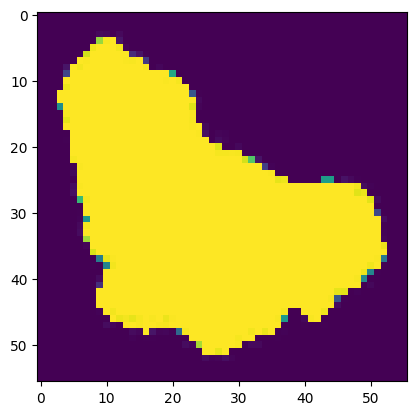

In [27]:
plt.imshow(dataset[0,:,:,0])

# Generacion de Modelos

In [28]:
# create and save a plot of generated images (reversed grayscale)
def save_plot_predict(examples, n):
  # plot images
  for i in range(n * n):
    # define subplot
    plt.subplot(n, n, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(examples[i, :, :, 0], cmap='gray_r')
  plt.show()

In [29]:
# load model
model = load_model('generator_2D_model_100.h5')
# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X = model.predict(latent_points)
# plot the result
save_plot_predict(X, 5)

OSError: No file or directory found at generator_2D_model_100.h5